In [29]:
import numpy as np
import glob2
import datetime
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
from matplotlib import pyplot as plt
from utils.detection.association_geodesic import squarize
plt.rcParams.update({'font.size': 18})
import math
from numpy.linalg import LinAlgError
import pandas as pd

from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound_model.spherical_sound_model import GridSphericalSoundModel as GridSoundModel, MonthlyHomogeneousSphericalSoundModel as HomogeneousSoundModel
from utils.detection.association_geodesic import compute_candidates, update_valid_grid, update_results, load_detections, compute_grids

In [30]:
# paths
CATALOG_PATH = "/media/plerolland/akoustik/MAHY"
DETECTIONS_DIR = f"../../../../data/detection/i_TiSSNet_checked-reboot-2"
SOUND_MODEL_PATH = f"../../../../data/sound_model"

# sound model definition
STATIONS = StationsCatalog(CATALOG_PATH).filter_out_undated().filter_out_unlocated()
mid_pos = np.mean([s.get_pos() for s in STATIONS], axis=0)
SOUND_MODEL = HomogeneousSoundModel([f"{SOUND_MODEL_PATH}/min-velocities_month-{i:02d}.nc" for i in range(1,13)],
                                    mid_pos)

In [31]:
MIN_ASSOCIATION_SIZE = 3

new_stations = {}
idx_to_det = {}
datasets = set([s.dataset for s in STATIONS])
for dataset in datasets:
    dets = glob2.glob(f"{DETECTIONS_DIR}/{dataset}/cache/detections*.pkl")[0]
    with open(dets, "rb") as f:
        DETECTIONS = pickle.load(f)

    idx_det = 0
    idx_to_det_local = {}
    for idx, s in enumerate(DETECTIONS.keys()):
        s.idx = idx  # indexes to store efficiently the associations
        DETECTIONS[s] = list(DETECTIONS[s])
        for i in range(len(DETECTIONS[s])):
            DETECTIONS[s][i] = np.concatenate((DETECTIONS[s][i], [idx_det]))
            idx_to_det_local[idx_det] = DETECTIONS[s][i]
            idx_det += 1
        DETECTIONS[s] = np.array(DETECTIONS[s])
    new_stations[dataset] = list(DETECTIONS.keys())
    idx_to_det[dataset] = idx_to_det_local
STATIONS = new_stations

In [33]:
LAT_BOUNDS = [-13.4, -12.4]
LON_BOUNDS = [45.25, 46.25]
GRID_SIZE = 150  # number of points along lat axis
PICK_UNCERTAINTY = 1
SOUND_SPEED_UNCERTAINTY = 0.25
MAX_CLOCK_DRIFT = 0.25
GRID_PATH = f"{DETECTIONS_DIR}/{list(datasets)[0]}/cache/grids_{LAT_BOUNDS[0]}_{LAT_BOUNDS[1]}_{LON_BOUNDS[0]}_{LON_BOUNDS[1]}_{GRID_SIZE}_{PICK_UNCERTAINTY}_{SOUND_SPEED_UNCERTAINTY}_{MAX_CLOCK_DRIFT}.pkl"
with open(GRID_PATH, "rb") as f:
    GRID_TO_COORDS, TDoA, MAX_TDoA, TDoA_UNCERTAINTIES = pickle.load(f)
GRID_TO_COORDS = np.array(GRID_TO_COORDS)

In [35]:
lats = [-13,-12.7]
lons = [45.45,45.85]

kept_assocations = {}

for dataset in tqdm(datasets):
    kept_assocations[dataset] = []
    asso_files = glob2.glob(f"{DETECTIONS_DIR}/{dataset}/cache/associations_{MIN_ASSOCIATION_SIZE}*.pkl")
    for file in asso_files:
        with open(file, "rb") as f:
            associations = pickle.load(f)
            for dets, valid_pts in associations:
                coords = np.array([GRID_TO_COORDS[i] for i in valid_pts])
                valid = (coords[:,0] >= lats[0]) & (coords[:,0] <= lats[1]) & (coords[:,1] >= lons[0]) & (coords[:,1] <= lons[1])
                if np.any(valid):
                    kept_assocations[dataset].append(dets)

  0%|          | 0/5 [00:00<?, ?it/s]

In [36]:
for dataset in kept_assocations.keys():
    print(len(kept_assocations[dataset]))
    kept_assocations[dataset].sort(key=lambda x: len(x), reverse=True)

21
112
97
158
2519


In [37]:
for dataset in kept_assocations.keys():
    for i in tqdm(range(len(kept_assocations[dataset]))):
        if len(kept_assocations[dataset][i]) == 2:
            continue

        dets = kept_assocations[dataset][i]
        dates = [idx_to_det[dataset][idx][0] for idx in dets[:,1]]
        s = [STATIONS[dataset][s]for s in dets[:,0]]
        pos = [s_.get_pos() for s_ in s]

        try:
            loc = SOUND_MODEL.localize_common_source(pos, dates)
        except LinAlgError:
            continue

        new_dets = [(station, date) for station, date in zip(s, dates)]
        kept_assocations[dataset][i] = (new_dets, loc)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/2519 [00:00<?, ?it/s]

In [9]:
results = {}

for dataset in kept_assocations.keys():
    results[dataset] = []
    used_dets = {s:set() for s in STATIONS[dataset]}
    sizes = np.array([len(a[0]) for a in kept_assocations[dataset]])

    for size in sorted(np.unique(sizes), reverse=True):
        relevant_associations = [a for a in kept_assocations[dataset] if len(a[0]) == size]
        scores = [a[1].cost for a in relevant_associations]
        order = np.argsort(scores)

        for idx in tqdm(order):
            available = True
            for s, d in relevant_associations[idx][0]:
                if d in used_dets[s]:
                    available = False
            if available:
                results[dataset].append(relevant_associations[idx])
                for s, d in relevant_associations[idx][0]:
                    used_dets[s].add(d)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/507 [00:00<?, ?it/s]

  0%|          | 0/1557 [00:00<?, ?it/s]

In [38]:
df = pd.DataFrame(columns=["date","lat", "lon", "timestamp", "nb_stations", "cost", "s1", "date1", "s2", "date2", "s3", "date3", "s4", "date4"])

i=0
for dataset in results.keys():
    for dets, loc in tqdm(results[dataset]):
        for j in range(len(dets)):
            df.loc[i, f"s{j}"] = dets[j][0]
            df.loc[i, f"date{j}"] = dets[j][1]
        min_date = np.min(np.array(dets)[:,1])
        df.loc[i, "date"] = min_date + datetime.timedelta(seconds=loc.x[0])
        df.loc[i, "timestamp"] = (df.loc[i, "date"] - datetime.datetime(1970,1,1)).total_seconds()
        df.loc[i, "lat"] = loc.x[1]
        df.loc[i, "lon"] = loc.x[2]
        df.loc[i, "cost"] = loc.cost
        df.loc[i, "nb_stations"] = len(dets)
        i += 1

df.to_csv("i_catalog.csv")

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/1362 [00:00<?, ?it/s]

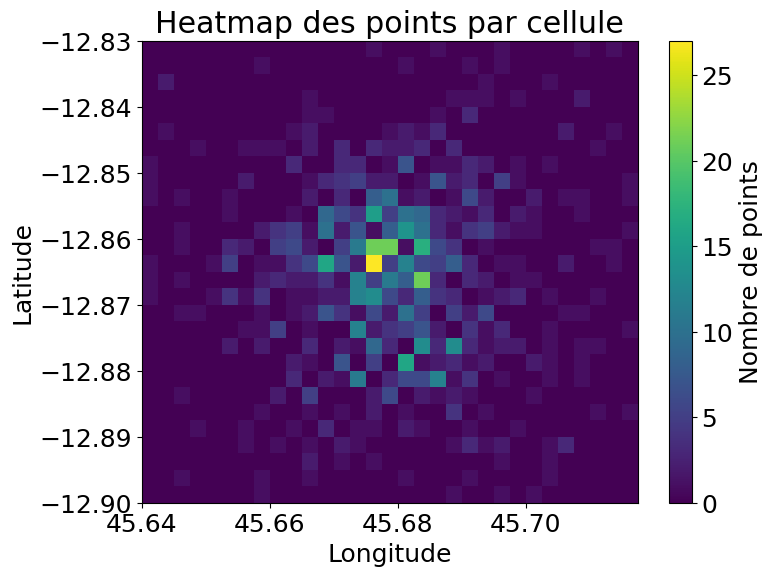

In [39]:
lat_step = 0.0025
lon_step = 0.0025

lat_bins = np.arange(-12.9, -12.83, lat_step)
lon_bins = np.arange(45.64, 45.72 , lon_step)

hist, y_edges, x_edges = np.histogram2d(df['lat'], df['lon'], bins=[lat_bins, lon_bins])
fig, ax = plt.subplots(figsize=(8, 6))
mesh = ax.pcolormesh(x_edges, y_edges, hist, cmap='viridis')
plt.colorbar(mesh, ax=ax, label='Nombre de points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Heatmap des points par cellule')
plt.show()